In [1]:
import os
import zipfile
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import EfficientNet_B0_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm


In [2]:
# Change this path based on your environment (e.g., Colab or local)
zip_path = "data.zip"
extract_path = "data"

# Unzip only if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted to: {extract_path}")
else:
    print(f"Data already extracted at: {extract_path}")

train_dir = os.path.join(extract_path, "data", "train")
val_dir = os.path.join(extract_path, "data", "val")
test_dir = os.path.join(extract_path, "data", "test")


Data already extracted at: data


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['Calculus', 'Caries', 'Gingivitis', 'Healthy', 'Hypodontia', 'Tooth Discoloration', 'Ulcers']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [5]:
EPOCHS = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []  

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)  

    print(f"Epoch [{epoch+1}/{EPOCHS}] --> "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc*100:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc*100:.2f}%")


Epoch 1/5: 100%|██████████| 153/153 [00:46<00:00,  3.27it/s]


Epoch [1/5] --> Train Loss: 0.9677, Train Acc: 69.01%, Val Loss: 0.6527, Val Acc: 77.46%


Epoch 2/5: 100%|██████████| 153/153 [00:46<00:00,  3.33it/s]


Epoch [2/5] --> Train Loss: 0.4618, Train Acc: 83.43%, Val Loss: 0.4502, Val Acc: 82.97%


Epoch 3/5: 100%|██████████| 153/153 [00:45<00:00,  3.33it/s]


Epoch [3/5] --> Train Loss: 0.3194, Train Acc: 87.13%, Val Loss: 0.3798, Val Acc: 84.09%


Epoch 4/5: 100%|██████████| 153/153 [00:46<00:00,  3.32it/s]


Epoch [4/5] --> Train Loss: 0.2533, Train Acc: 88.67%, Val Loss: 0.4226, Val Acc: 84.33%


Epoch 5/5: 100%|██████████| 153/153 [00:46<00:00,  3.32it/s]


Epoch [5/5] --> Train Loss: 0.2215, Train Acc: 89.65%, Val Loss: 0.4053, Val Acc: 84.25%


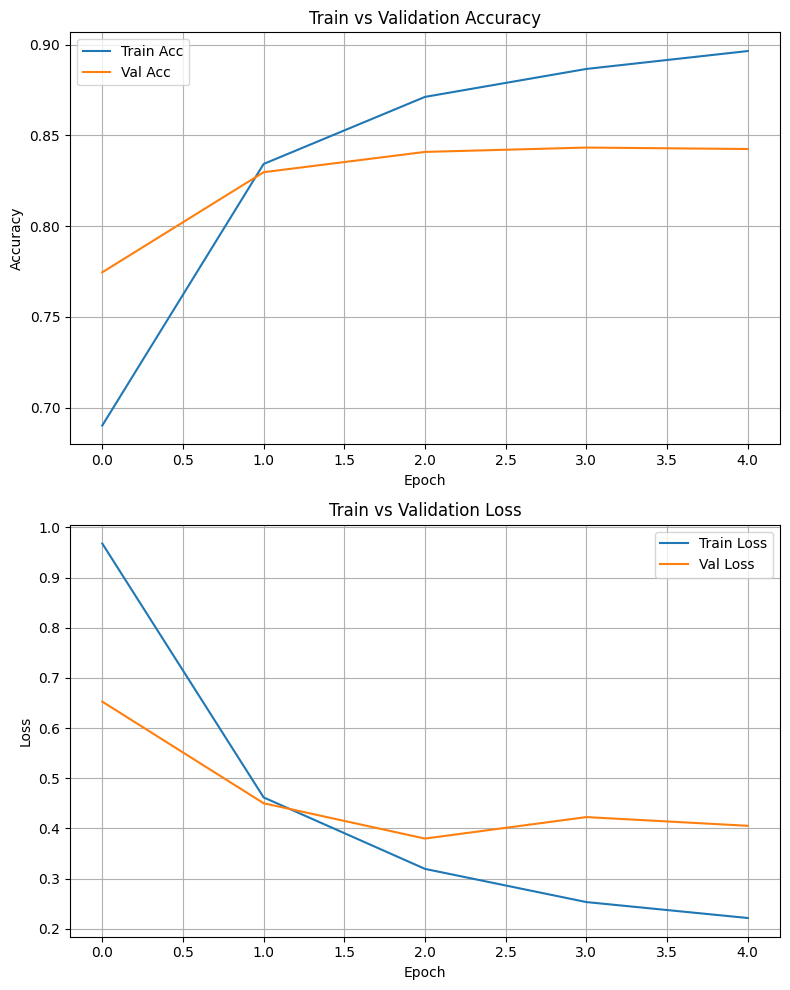

In [6]:
plt.figure(figsize=(8, 10))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Classification Report:

                     precision    recall  f1-score   support

           Calculus       0.66      0.68      0.67       130
             Caries       0.89      0.73      0.80        22
         Gingivitis       0.73      0.83      0.78       234
            Healthy       1.00      0.56      0.72        82
         Hypodontia       0.86      0.89      0.87        35
Tooth Discoloration       0.99      1.00      1.00       202
             Ulcers       0.96      1.00      0.98        27

           accuracy                           0.83       732
          macro avg       0.87      0.81      0.83       732
       weighted avg       0.84      0.83      0.82       732


Confusion Matrix:

[[ 89   1  40   0   0   0   0]
 [  3  16   1   0   0   1   1]
 [ 38   1 194   0   1   0   0]
 [  2   0  29  46   4   1   0]
 [  2   0   2   0  31   0   0]
 [  0   0   0   0   0 202   0]
 [  0   0   0   0   0   0  27]]


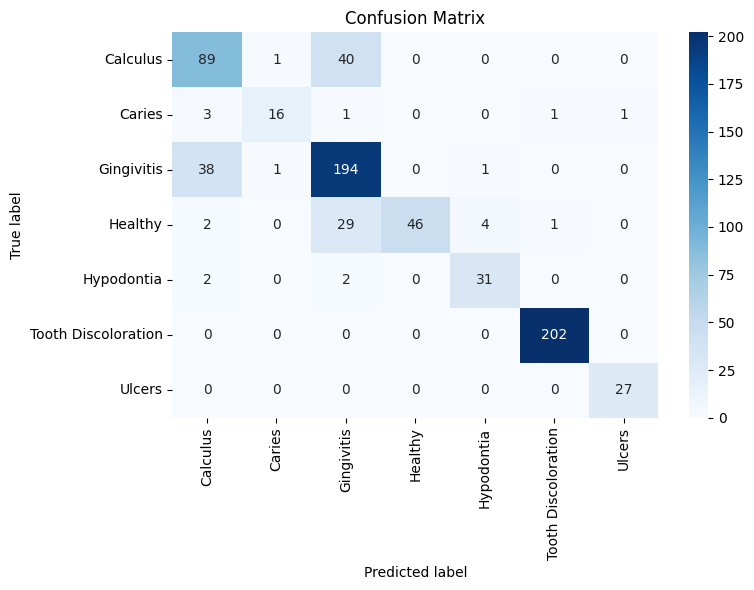

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

# Put the model in evaluation mode
model.eval()

y_true = []
y_pred = []

# Inference on test data
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# CLASSIFICATION REPORT
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# RAW CONFUSION MATRIX
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n")
print(cm)

# PLOTTED CONFUSION MATRIX HEATMAP
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


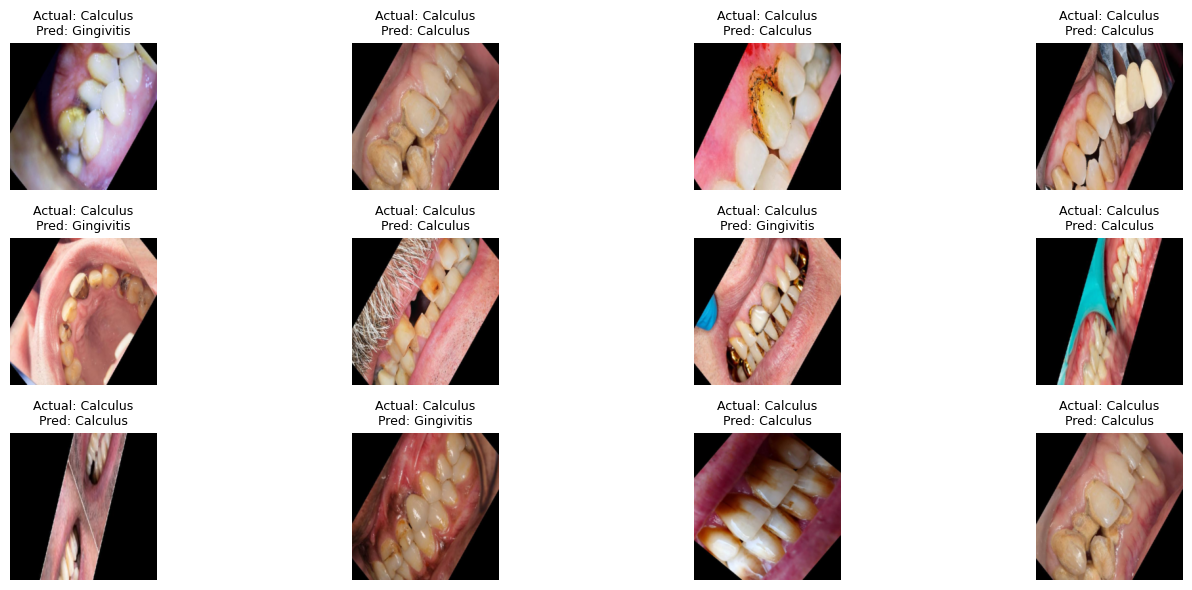

In [8]:
import matplotlib.pyplot as plt

# Show N images with predicted and actual labels
def show_predictions(model, dataloader, class_names, device, num_images=12):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 6))
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

                plt.subplot(3, 4, images_shown + 1)
                plt.imshow(img)
                plt.axis("off")
                plt.title(f"Actual: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}", fontsize=9)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

# Call the function
show_predictions(model, test_loader, class_names, device, num_images=12)
